```
Sayed Hesam Alavian 

```



In [ ]:
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import DataFrame
from string import punctuation
import statistics
from math import log2
from collections import Counter
import seaborn as sn

#Classifier by bag of words

In [ ]:
# read dataset
url = 'https://drive.google.com/u/0/uc?id=1eiHZsQca-0nP-WAZsAdU6y3LbjH6nitx&export=download'
data = pd.read_csv(url) #Read Dataset
data.head()

,type,text
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


In [ ]:
data = data.rename(columns={"type": "class_label", "text":"Text_mail"}) #chang collemns name
data.head()

,class_label,Text_mail
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


<div dir=rtl>
بدست آوردن فراوانی هر کلاس 
</div>

In [ ]:
data['class_label'].value_counts(normalize=True)

ham     0.866719
spam    0.133281
Name: class_label, dtype: float64

<div 

<div dir=rtl>
تقسیم کردن دیتاست به مجموعه های آموزش و تست 
</div>

In [ ]:
# Randomize the dataset
data_randomized = data.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print('train set shape: ',training_set.shape)
print('test set shape: ',test_set.shape)

train set shape:  (4058, 2)
test set shape:  (1014, 2)


In [ ]:
training_set['class_label'].value_counts(normalize=True)

ham     0.863972
spam    0.136028
Name: class_label, dtype: float64

In [ ]:
test_set['class_label'].value_counts(normalize=True)

ham     0.877712
spam    0.122288
Name: class_label, dtype: float64

###data cleaning

<div dir=rtl>
پیش پردازش ساده 
</div>

In [ ]:
# Before cleaning
training_set.head()

,class_label,Text_mail
0,ham,Watch lor. I saw a few swatch one i thk quite ...
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...
2,ham,No just send to you. Bec you in temple na.
3,ham,How u doin baby girl ?? hope u are okay every ...
4,ham,No da:)he is stupid da..always sending like th...


In [ ]:
# After cleaning
training_set['Text_mail'] = training_set['Text_mail'].str.replace(
   '\W', ' ') # Removes punctuation
training_set['Text_mail'] = training_set['Text_mail'].str.lower()
training_set.head()

,class_label,Text_mail
0,ham,watch lor i saw a few swatch one i thk quite ...
1,ham,r u sam p in eachother if we meet we can go ...
2,ham,no just send to you bec you in temple na
3,ham,how u doin baby girl hope u are okay every ...
4,ham,no da he is stupid da always sending like th...


<div dir=rtl>
ساخت یک دیکشنری از لغات استفاده شده در پیام ها
</div>

In [ ]:
training_set['Text_mail'] = training_set['Text_mail'].str.split() #splited massages

vocabulary = []
for Text_mail in training_set['Text_mail']:
   for word in Text_mail:
      vocabulary.append(word)

vocabulary = list(set(vocabulary)) #find unique words

In [ ]:
len(vocabulary)

7493

In [ ]:
word_counts_per_text = {unique_word: [0] * len(training_set['Text_mail']) for unique_word in vocabulary}

for index, Text_mail in enumerate(training_set['Text_mail']):
   for word in Text_mail:
      word_counts_per_text[word][index] += 1

<div dir=rtl>
ساخت یک ماتریس از لغت های یکتا
</div>

In [ ]:
word_counts = pd.DataFrame(word_counts_per_text)

word_counts.head()

<div dir=rtl>
چسباندن ماتریس لغات به ماتریس مجموعه آموزش
</div>

In [ ]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()


In [ ]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['class_label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['class_label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['Text_mail'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['Text_mail'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

In [ ]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
   n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
   p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
   parameters_spam[word] = p_word_given_spam

   n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
   p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
   parameters_ham[word] = p_word_given_ham

In [ ]:
import re

def classify_test_set(message):
   '''
   Evaluate test_set
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham:
         p_ham_given_message *= parameters_ham[word]

   if p_ham_given_message > p_spam_given_message:
      return 'ham'
   elif p_spam_given_message > p_ham_given_message:
      return 'spam'
   else:
      return 'needs human classification'

<div dir=rtl>
ارزیابی مجموعه تست توسط پارامترهای بدست آمده از مجموعه آموزش و ساخت یک ستون پیشبینی برای برچسب زدن پیش بینی ها
</div>

In [ ]:
test_set['predicted'] = test_set['Text_mail'].apply(classify_test_set)
test_set.head()

,class_label,Text_mail,predicted
0,ham,He like not v shock leh. Cos telling shuhui is...,ham
1,ham,I'm job profile seems like bpo..,ham
2,ham,Ok then i come n pick u at engin?,ham
3,ham,You do what all you like,ham
4,ham,Dear :-/ why you mood off. I cant drive so i b...,ham


##classification reports

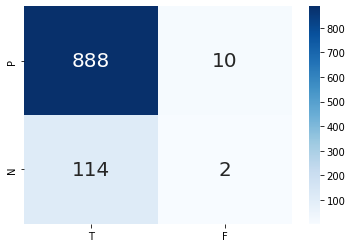

True Positive = 888 False Negative = 10 True Negative 114 False Negative = 2
Correct : 1002
Incorrect : 12
Precision :  0.9888641425389755
Recall :  0.9977528089887641
Accuracy : 0.9881656804733728
F1_Measure :  0.9932885906040269
specificity :  0.9193548387096774


In [ ]:
correct = 0
total = test_set.shape[0]
TP = FP = TN = FN =0
for row in test_set.iterrows():
   row = row[1]
   if row['class_label'] == row['predicted']:
      correct += 1
   if row['class_label'] == 'ham':
     if row['predicted'] == 'ham':
        TP+=1
     else:
        FN+=1
   else:
     if row['predicted'] == 'ham':
        FP+=1
     else:
        TN+=1
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
F1_Measure = (2 * precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

array = [[TP,FP],[TN,FN]] 
df_cm = pd.DataFrame(array, ['P','N'], ['T','F'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g',annot_kws={"size": 20})
plt.show()

print('True Positive =', TP, 'False Negative =', FP,'True Negative', TN,'False Negative =', FN)
print('Correct :', correct)
print('Incorrect :', total - correct)
print('Precision : ', precision)
print('Recall : ', recall)
print('Accuracy :', accuracy)
print('F1_Measure : ', F1_Measure)
print('specificity : ', specificity)

<div dir=rtl>
برچسب زدن مجموعه ارزیابی اصلی خواسته شده در تمرین
</div>

##Predicted gold testset

In [ ]:
url_eval = 'https://drive.google.com/u/0/uc?id=1ym6-KsCfkXPivS4gm18-45q4mTiBbNFm&export=download'
eval_set = pd.read_csv(url_eval) #Read Dataset Evalution
eval_set.head()

,id,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,2,Ok lar... Joking wif u oni...
2,3,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,U dun say so early hor... U c already then say...
4,5,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
eval_set['predicted'] = eval_set['text'].apply(classify_test_set)
eval_set.head()

,id,text,predicted
0,1,"Go until jurong point, crazy.. Available only ...",ham
1,2,Ok lar... Joking wif u oni...,ham
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,4,U dun say so early hor... U c already then say...,ham
4,5,"Nah I don't think he goes to usf, he lives aro...",ham


In [ ]:
del eval_set['text']
eval_set = eval_set.rename(columns={"predicted": "type"})
eval_set.head()

,id,type
0,1,ham
1,2,ham
2,3,spam
3,4,ham
4,5,ham


<div dir=rtl>
ذخیره و دانلود فایل مجموعه ارزیابی برچسب خورده طبق فرمت خواسته شده
</div>

In [ ]:
eval_set.to_csv('99210323_eval_output_BagOfWord.csv',index=False)


In [ ]:
from google.colab import files
files.download('99210323_eval_output_BagOfWord.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div dir=rtl>
اجرای دسته بندی نیِو بیز با استفاده از ویژگی ها ( بدون حذف  ویژگی ها و انتخاب بهترین ویژگی ها)
</div>

#Classifier by features

In [ ]:
# read dataset
url = 'https://drive.google.com/u/0/uc?id=1eiHZsQca-0nP-WAZsAdU6y3LbjH6nitx&export=download'
data_f = pd.read_csv(url) #Read Dataset for features
data_f.head()

,type,text
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


In [ ]:
data_f = data_f.rename(columns={"type": "class_label", "text":"Text_mail"})
data_f.head()

,class_label,Text_mail
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


In [ ]:
data_f['class_label'].value_counts(normalize=True)

ham     0.866719
spam    0.133281
Name: class_label, dtype: float64

In [ ]:
# Randomize the dataset
data_randomized_f = data_f.sample(frac=1, random_state=1)

# Calculate index for split
training_test_f_index = round(len(data_randomized_f) * 0.8)

# Split into training and test sets
training_set_f = data_randomized_f[:training_test_f_index].reset_index(drop=True)
test_set_f = data_randomized_f[training_test_f_index:].reset_index(drop=True)

print('train set shape: ',training_set_f.shape)
print('test set shape: ',test_set_f.shape)

train set shape:  (4058, 2)
test set shape:  (1014, 2)


In [ ]:
training_set_f['class_label'].value_counts(normalize=True)

ham     0.863972
spam    0.136028
Name: class_label, dtype: float64

In [ ]:
test_set_f['class_label'].value_counts(normalize=True)

ham     0.877712
spam    0.122288
Name: class_label, dtype: float64

In [ ]:
training_set_f.head()

,class_label,Text_mail
0,ham,Watch lor. I saw a few swatch one i thk quite ...
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...
2,ham,No just send to you. Bec you in temple na.
3,ham,How u doin baby girl ?? hope u are okay every ...
4,ham,No da:)he is stupid da..always sending like th...


## preprocessing using NLTK and features extraction

In [ ]:
!pip install pyspellchecker==0.5.6
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

     |████████████████████████████████| 2.5 MB 7.3 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
numbers = "0123456789"

<div dir=rtl>
برای پیش پردازش پیام ها و استخراج ویژگی ها کلاس زیر تعریف شده است که شامل توابع مربوطه هست و برای مجموعه داده های آموزش ، تست و ارزیابی نهایی استفاده میشود.


*   پیش پردازش درست کردن کلمات از نظر املایی کامنت شده است و به علت زمان اجرای بالا اجرا نشده است.
*   30 ویژگی استخراج شده است که در کد های مربوطه کامنت گذاری شده است و مشخص می باشند و با #F ذخیره می شوند.


</div>

In [ ]:
class preprocessing_features_extraction:
  def __init__(self,df):
    self.df = df

################################ preprocessing functions ###############################

  def preprocessing (self,df):
    df['clean'] = df['Text_mail'].str.lower()

    def remove_whitespace(text):
        return  " ".join(text.split())

    df['clean'] = df['clean'].apply(remove_whitespace)

    def remove_tag(text):    
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub(r'', text) 
    df['clean'] = df['clean'].apply(remove_tag)

    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)
    df['clean'] = df['clean'].apply(remove_urls)

    # def spell_check(text):   
    #     result = []
    #     spell = SpellChecker()
    #     for word in text:
    #         correct_word = spell.correction(word)
    #         result.append(correct_word)
    #     return result
    # df['clean'] = df['clean'].apply(spell_check)

    df['remove_number'] = df['clean'].apply(lambda text : re.sub(r'\d+', '', text))

    def remove_punct(text):
        
        tokenizer = RegexpTokenizer(r"\w+")
        lst=tokenizer.tokenize(' '.join(text.split()))
        return " ".join(lst)
    df['remove_punct'] = df['remove_number'].apply(remove_punct)

    df['tokenize_word'] = df['remove_punct'].apply(lambda X: word_tokenize(X))

    def lemmatization(text):
        
        result=[]
        wordnet = WordNetLemmatizer()
        for token,tag in pos_tag(text):
            pos=tag[0].lower()
            
            if pos not in ['a', 'r', 'n', 'v']:
                pos='n'
                
            result.append(wordnet.lemmatize(token,pos))
        
        return result
    df['lematization'] = df['tokenize_word'].apply(lemmatization)

    return df

################################features_extractor functions ###############################

  def features_extractor(self, df):
    ############### Character Based Features #############

    #length of document
    C = df['Text_mail'].apply(lambda text : len(text))
    df['F1'] = C
    def count_alphabet(text):
      count = 0
      for ch in text:
          if ch in alphabet:
              count = count + 1
      return count
    #number of alphabet characters in each document
    df['F2'] = df['clean'].apply(lambda text : count_alphabet(text)) / C
    def count_digits(text):
      count = 0
      for ch in text:
          if ch in numbers:
              count = count + 1
      return count
    #number of digital characters in each document
    df['F3'] = df['clean'].apply(lambda text : count_digits(text)) / C
    #number of white space characters in each document
    df['F4'] = df['Text_mail'].apply(lambda text : text.count(" ")) / C
    #number of tab characters in each document
    df['F5'] = df['Text_mail'].apply(lambda text : text.count("\t")) / C
    def count_special_chars(text):
      count = 0
      for ch in text:
          if ch in punctuation:
              count = count + 1
      return count
    #number of digital characters in each document
    df['F6'] = df['Text_mail'].apply(lambda text : count_special_chars(text)) / C

    ############### Word Based Features    #############
    
    #number of words in each document
    N = df['tokenize_word'].apply(lambda lst : len(lst))
    df['N'] = N
    df['F7'] = N
    #mean of words length in each document
    df['F8'] = df['tokenize_word'].apply(lambda lst : statistics.mean(list(map(lambda x : len(x) , lst+['']))))
    #number of unique words in each document
    V = df['tokenize_word'].apply(lambda lst : len(set(lst)))
    df['V'] = V
    df['F9'] = V/N
    #number of words longer than 4 characters
    df['F10'] = df['tokenize_word'].apply(lambda lst : sum(1 for x in lst if len(x) >= 5))/N
    #number of words shhorter than 4 characters
    df['F11'] = df['tokenize_word'].apply(lambda lst : sum(1 for x in lst if len(x) <= 3))/N
    def get_word_by_count(list_of_words , count):
      dict_count = Counter(list_of_words)
      words = []
      for key,value in dict_count.items():
          if value == count:
              words.append(key)
      return len(words)
    #Hapax Legomena
    df['F12'] = df['tokenize_word'].apply(lambda lst : get_word_by_count(lst , 1))/N
    #Hapax Dislegomena
    df['F13'] = df['tokenize_word'].apply(lambda lst : get_word_by_count(lst , 2))/N
    def Yule_K(v,n,list_of_words):    
      if n == 0:
        return 0
      val = -1/n
      for i in range(1,v+1):
        try:
          val = val + get_word_by_count(list_of_words,i)*(i/n)**2
        except ZeroDivisionError:
          return 0
      val = val * 10**4
      return val
    def Simpsons(v,n,list_of_words):
      val = 0
      for i in range(1,v+1):
          try:
              val = val + get_word_by_count(list_of_words,i)*(i/n)*(i-1)/(n-1)
          except ZeroDivisionError:
              return None
      return val
    def Sichel(v,list_of_words):
      val = get_word_by_count(list_of_words,2)/(v+1)
      return val
    def Honores(v,n,list_of_words):
      try:
          val = 100 * (math.log10(n)) / (1 - get_word_by_count(list_of_words,1) / (v+1))
      except:
          return 0
      return val
    df['F14'] = df.apply(lambda row : Yule_K(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F15'] = df.apply(lambda row : Simpsons(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F16'] = df.apply(lambda row : Sichel(row['V'] , row['tokenize_word']) , axis=1)
    df['F17'] = df.apply(lambda row : Honores(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F15'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)
    df['F17'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)
    def entropy(list_of_words):
        dict_count = Counter(list_of_words)
        total = sum(dict_count.values())
        return sum(freq / total * log2(total / freq) for freq in dict_count.values())
    df['F18'] = df['tokenize_word'].apply(lambda lst : entropy(lst))

   ############### Syntax Based Features    #############

    df['F19'] = df['clean'].apply(lambda text : text.count("'"))/C
    df['F20'] = df['clean'].apply(lambda text : text.count("،"))/C
    df['F21'] = df['clean'].apply(lambda text : text.count("."))/C
    df['F22'] = df['clean'].apply(lambda text : text.count(":"))/C
    df['F23'] = df['clean'].apply(lambda text : text.count(";"))/C
    df['F24'] = df['clean'].apply(lambda text : text.count("؟"))/C
    df['F25'] = df['clean'].apply(lambda text : len(re.findall("؟؟+" , text)))/C
    df['F26'] = df['clean'].apply(lambda text : text.count("!"))/C
    df['F27'] = df['clean'].apply(lambda text : len(re.findall("!!+" , text)))/C
    df['F28'] = df['clean'].apply(lambda text : len(re.findall("(\.)(\.)+" , text)))/C

   ############### Structural Features    #############

   #number of document lines
    df['F29'] = df['Text_mail'].apply(lambda text : text.count("\n"))
    def avg_length_of_nonempty_lines(text):
        all_lines = text.split("\n")
        length_of_non_empty_lines = 0
        number_of_non_empty_lines = 0
        for line in all_lines:
            if len(line.strip()) != 0:
                number_of_non_empty_lines = number_of_non_empty_lines + 1
                length_of_non_empty_lines = length_of_non_empty_lines + len(line)
        try:
            return length_of_non_empty_lines / number_of_non_empty_lines
        except ZeroDivisionError:
            return 0
    df['F30'] = df['Text_mail'].apply(lambda text : avg_length_of_nonempty_lines(text))
    df = df.drop(columns=['clean','remove_number','remove_punct','tokenize_word','lematization','N','V'])

    return df

In [ ]:
train = preprocessing_features_extraction(training_set_f) 

In [ ]:
train_set = train.preprocessing(training_set_f) #preprocessing
train_set.head()

,class_label,Text_mail,clean,remove_number,remove_punct,tokenize_word,lematization
0,ham,Watch lor. I saw a few swatch one i thk quite ...,watch lor. i saw a few swatch one i thk quite ...,watch lor. i saw a few swatch one i thk quite ...,watch lor i saw a few swatch one i thk quite o...,"[watch, lor, i, saw, a, few, swatch, one, i, t...","[watch, lor, i, saw, a, few, swatch, one, i, t..."
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,r u &sam p in eachother. if we meet we can go ...,r u &sam p in eachother. if we meet we can go ...,r u sam p in eachother if we meet we can go my...,"[r, u, sam, p, in, eachother, if, we, meet, we...","[r, u, sam, p, in, eachother, if, we, meet, we..."
2,ham,No just send to you. Bec you in temple na.,no just send to you. bec you in temple na.,no just send to you. bec you in temple na.,no just send to you bec you in temple na,"[no, just, send, to, you, bec, you, in, temple...","[no, just, send, to, you, bec, you, in, temple..."
3,ham,How u doin baby girl ?? hope u are okay every ...,how u doin baby girl ?? hope u are okay every ...,how u doin baby girl ?? hope u are okay every ...,how u doin baby girl hope u are okay every tim...,"[how, u, doin, baby, girl, hope, u, are, okay,...","[how, u, doin, baby, girl, hope, u, be, okay, ..."
4,ham,No da:)he is stupid da..always sending like th...,no da:)he is stupid da..always sending like th...,no da:)he is stupid da..always sending like th...,no da he is stupid da always sending like this...,"[no, da, he, is, stupid, da, always, sending, ...","[no, da, he, be, stupid, da, always, send, lik..."


In [ ]:
train_set = train.features_extractor(training_set_f) #feature extraction
train_set.head()

,class_label,Text_mail,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,ham,Watch lor. I saw a few swatch one i thk quite ...,87,0.678161,0.045977,0.218391,0.0,0.057471,19,2.950000,0.894737,0.210526,0.736842,0.842105,0.000000,166.204986,0.017544,0.000000,0,3.997670,0.0,0.0,0.057471,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011494,0,87.0
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56,0.696429,0.017857,0.250000,0.0,0.035714,14,2.600000,0.928571,0.142857,0.785714,0.857143,0.071429,102.040816,0.010989,0.071429,0,3.664498,0.0,0.0,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,56.0
2,ham,No just send to you. Bec you in temple na.,42,0.738095,0.000000,0.214286,0.0,0.047619,10,2.818182,0.900000,0.100000,0.700000,0.800000,0.100000,200.000000,0.022222,0.100000,0,3.121928,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,42.0
3,ham,How u doin baby girl ?? hope u are okay every ...,97,0.731959,0.000000,0.237113,0.0,0.030928,23,2.958333,0.869565,0.130435,0.521739,0.782609,0.043478,151.228733,0.015810,0.047619,0,4.229871,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010309,0.0,0.000000,0,97.0
4,ham,No da:)he is stupid da..always sending like th...,102,0.764706,0.000000,0.147059,0.0,0.088235,20,3.714286,0.900000,0.400000,0.500000,0.800000,0.100000,100.000000,0.010526,0.105263,0,4.121928,0.0,0.0,0.029412,0.029412,0.0,0.0,0.0,0.000000,0.0,0.009804,0,102.0


##Naive bayes by featurs

In [ ]:
# Isolating spam and ham messages first
spam_messages = train_set[train_set['class_label'] == 'spam']
ham_messages = train_set[train_set['class_label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_set)
p_ham = len(ham_messages) / len(train_set)

# N_Features
featurs_list = train_set.columns[2:]
n_features = len(featurs_list) # number of features

# Laplace smoothing
alpha = 0.01

avg_featurs_spam = {}
avg_featurs_ham = {}
for feature in featurs_list:
  avg_featurs_spam[feature] = spam_messages[feature].mean() 
  avg_featurs_ham[feature] = ham_messages[feature].mean()

<div dir=rtl>
میانگین هر ویژگی برای هر کلاس در نمودار زیر نمایش داده شده است که همانطور که مشاهده میکنید برخی از این ویژگی ها اختلاف زیادی در کلاس ها دارند که برای طبقه بندی مناسب میباشند. ولی در این قسمت ( مدل ) طبقه بندی را با تمام ویژگی ها انجام داده و در قسمت نهایی عمل حذف ویژگی ها و انتخاب بهترین ها را انجام میدهیم.
</div>

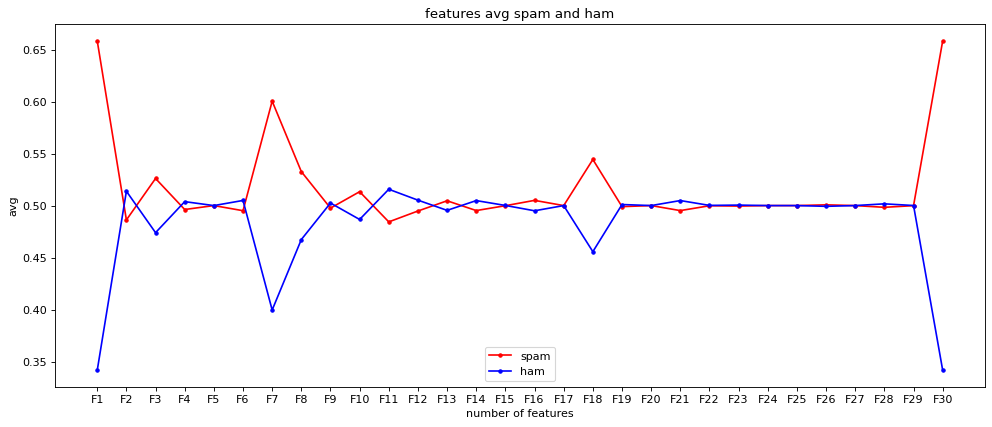

In [ ]:
x = np.array(list(avg_featurs_spam.values()))
y = np.array(list(avg_featurs_ham.values()))
figure(figsize=(15, 6), dpi=80)
plt.plot(featurs_list,(x+1)/(x+y+2),label="spam", color='red',marker='.')
plt.plot(featurs_list,(y+1)/(x+y+2),label="ham", color='blue',marker='.')
plt.xlabel('number of features')
plt.ylabel('avg')
plt.legend(['spam','ham'])
plt.title('features avg spam and ham')
plt.show()

In [ ]:
import re

def classify_f_test_set(df): # classify by features test set
   '''
   Evaluate test_set
   '''
   ########################### preprocessing and extract features ############# 
   test = preprocessing_features_extraction(df)
   test_set = test.preprocessing(df)
   test_set = test.features_extractor(df)



   test_set.insert(2, "predicted", "Any")
   
   for index in range(len(test_set)):
      p_spam_given_message = p_spam
      p_ham_given_message = p_ham
      for feature in featurs_list:            
            distance_parameters_spam = abs(avg_featurs_spam[feature] - test_set[feature][index])
            distance_parameters_ham = abs(avg_featurs_ham[feature] - test_set[feature][index])
            p_parameter_spam = 1 - (distance_parameters_spam  / ((distance_parameters_spam + distance_parameters_ham + alpha )))
            p_parameter_ham = 1 -  (distance_parameters_ham  /  ((distance_parameters_spam + distance_parameters_ham + alpha )))
            p_spam_given_message *= p_parameter_spam
            p_ham_given_message *= p_parameter_ham    
      if  p_ham_given_message >= p_spam_given_message:
        test_set['predicted'][index] = 'ham'
      else:
        test_set['predicted'][index] = 'spam'
   return test_set

In [ ]:
test_set_f = classify_f_test_set(test_set_f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_set_f = test_set_f.drop(test_set_f.columns[3:], axis=1)
test_set_f.head()

,class_label,Text_mail,predicted
0,ham,He like not v shock leh. Cos telling shuhui is...,spam
1,ham,I'm job profile seems like bpo..,ham
2,ham,Ok then i come n pick u at engin?,ham
3,ham,You do what all you like,ham
4,ham,Dear :-/ why you mood off. I cant drive so i b...,ham


##classification reports

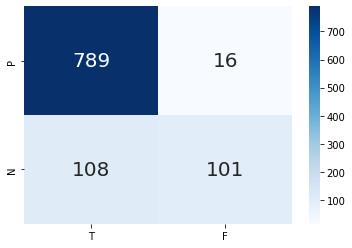

True Positive = 789 False Negative = 16 True Negative 108 False Negative = 101
Correct : 897
Incorrect : 117
Precision :  0.9801242236024845
Recall :  0.8865168539325843
Accuracy : 0.8846153846153846
F1_Measure :  0.9309734513274336
specificity :  0.8709677419354839


In [ ]:
correct = 0
total = test_set_f.shape[0]
TP = FP = TN = FN =0
for row in test_set_f.iterrows():
   row = row[1]
   if row['class_label'] == row['predicted']:
      correct += 1
   if row['class_label'] == 'ham':
     if row['predicted'] == 'ham':
        TP+=1
     else:
        FN+=1
   else:
     if row['predicted'] == 'ham':
        FP+=1
     else:
        TN+=1
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
F1_Measure = (2 * precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

array = [[TP,FP],[TN,FN]] 
df_cm = pd.DataFrame(array, ['P','N'], ['T','F'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g',annot_kws={"size": 20})
plt.show()

print('True Positive =', TP, 'False Negative =', FP,'True Negative', TN,'False Negative =', FN)
print('Correct :', correct)
print('Incorrect :', total - correct)
print('Precision : ', precision)
print('Recall : ', recall)
print('Accuracy :', accuracy)
print('F1_Measure : ', F1_Measure)
print('specificity : ', specificity)

##Predicted gold testset

In [ ]:
url_eval_f = 'https://drive.google.com/u/0/uc?id=1ym6-KsCfkXPivS4gm18-45q4mTiBbNFm&export=download'
eval_set_f = pd.read_csv(url_eval_f) #Read Dataset evaluation
eval_set_f = eval_set_f.rename(columns={"text": "Text_mail"})
eval_set_f.head()

,id,Text_mail
0,1,"Go until jurong point, crazy.. Available only ..."
1,2,Ok lar... Joking wif u oni...
2,3,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,U dun say so early hor... U c already then say...
4,5,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
eval_set_f = classify_f_test_set(eval_set_f)
eval_set_f = eval_set_f.drop(eval_set_f.columns[3:], axis=1)
eval_set_f.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,Text_mail,predicted
0,1,"Go until jurong point, crazy.. Available only ...",spam
1,2,Ok lar... Joking wif u oni...,ham
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,4,U dun say so early hor... U c already then say...,ham
4,5,"Nah I don't think he goes to usf, he lives aro...",ham


In [ ]:
del eval_set_f['Text_mail']
eval_set_f = eval_set_f.rename(columns={"predicted": "type"})
eval_set_f.head()

,id,type
0,1,spam
1,2,ham
2,3,spam
3,4,ham
4,5,ham


In [ ]:
eval_set_f.to_csv('99210323_eval_output_Features.csv',index=False)


In [ ]:
from google.colab import files
files.download('99210323_eval_output_Features.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Classifier by features selection

In [ ]:
# read dataset
url = 'https://drive.google.com/u/0/uc?id=1eiHZsQca-0nP-WAZsAdU6y3LbjH6nitx&export=download'
data_fs = pd.read_csv(url) #Read Dataset for features
data_fs.head()

,type,text
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


In [ ]:
data_fs = data_fs.rename(columns={"type": "class_label", "text":"Text_mail"})
data_fs.head()

,class_label,Text_mail
0,ham,"Fighting with the world is easy, u either win ..."
1,ham,When can Ì_ come out?
2,ham,Check with nuerologist.
3,ham,Lolnice. I went from a fish to ..water.?
4,spam,+123 Congratulations - in this week's competit...


In [ ]:
data_fs['class_label'].value_counts(normalize=True)

ham     0.866719
spam    0.133281
Name: class_label, dtype: float64

In [ ]:
# Randomize the dataset
data_randomized_fs = data_fs.sample(frac=1, random_state=1)

# Calculate index for split
training_test_fs_index = round(len(data_randomized_fs) * 0.8)

# Split into training and test sets
training_set_fs = data_randomized_fs[:training_test_fs_index].reset_index(drop=True)
test_set_fs = data_randomized_fs[training_test_fs_index:].reset_index(drop=True)

print('train set shape: ',training_set_fs.shape)
print('test set shape: ',test_set_fs.shape)

train set shape:  (4058, 2)
test set shape:  (1014, 2)


In [ ]:
training_set_fs['class_label'].value_counts(normalize=True)

ham     0.863972
spam    0.136028
Name: class_label, dtype: float64

In [ ]:
test_set_fs['class_label'].value_counts(normalize=True)

ham     0.877712
spam    0.122288
Name: class_label, dtype: float64

In [ ]:
training_set_fs.head()

,class_label,Text_mail
0,ham,Watch lor. I saw a few swatch one i thk quite ...
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...
2,ham,No just send to you. Bec you in temple na.
3,ham,How u doin baby girl ?? hope u are okay every ...
4,ham,No da:)he is stupid da..always sending like th...


## preprocessing using NLTK and features extraction

In [ ]:
!pip install pyspellchecker==0.5.6
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
numbers = "0123456789"

In [ ]:
class preprocessing_features_extraction:
  def __init__(self,df):
    self.df = df

################################ preprocessing function ###############################

  def preprocessing (self,df):
    df['clean'] = df['Text_mail'].str.lower()

    def remove_whitespace(text):
        return  " ".join(text.split())

    df['clean'] = df['clean'].apply(remove_whitespace)

    def remove_tag(text):    
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub(r'', text) 
    df['clean'] = df['clean'].apply(remove_tag)

    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)
    df['clean'] = df['clean'].apply(remove_urls)

    # def spell_check(text):   
    #     result = []
    #     spell = SpellChecker()
    #     for word in text:
    #         correct_word = spell.correction(word)
    #         result.append(correct_word)
    #     return result
    # df['clean'] = df['clean'].apply(spell_check)

    df['remove_number'] = df['clean'].apply(lambda text : re.sub(r'\d+', '', text))

    def remove_punct(text):
        
        tokenizer = RegexpTokenizer(r"\w+")
        lst=tokenizer.tokenize(' '.join(text.split()))
        return " ".join(lst)
    df['remove_punct'] = df['remove_number'].apply(remove_punct)

    df['tokenize_word'] = df['remove_punct'].apply(lambda X: word_tokenize(X))

    def lemmatization(text):
        
        result=[]
        wordnet = WordNetLemmatizer()
        for token,tag in pos_tag(text):
            pos=tag[0].lower()
            
            if pos not in ['a', 'r', 'n', 'v']:
                pos='n'
                
            result.append(wordnet.lemmatize(token,pos))
        
        return result
    df['lematization'] = df['tokenize_word'].apply(lemmatization)

    return df

################################features_extractor function ###############################

  def features_extractor(self, df):
    ############### Character Based Features #############

    #length of document
    C = df['Text_mail'].apply(lambda text : len(text))
    df['F1'] = C
    def count_alphabet(text):
      count = 0
      for ch in text:
          if ch in alphabet:
              count = count + 1
      return count
    #number of alphabet characters in each document
    df['F2'] = df['clean'].apply(lambda text : count_alphabet(text)) / C
    def count_digits(text):
      count = 0
      for ch in text:
          if ch in numbers:
              count = count + 1
      return count
    #number of digital characters in each document
    df['F3'] = df['clean'].apply(lambda text : count_digits(text)) / C
    #number of white space characters in each document
    df['F4'] = df['Text_mail'].apply(lambda text : text.count(" ")) / C
    #number of tab characters in each document
    df['F5'] = df['Text_mail'].apply(lambda text : text.count("\t")) / C
    def count_special_chars(text):
      count = 0
      for ch in text:
          if ch in punctuation:
              count = count + 1
      return count
    #number of digital characters in each document
    df['F6'] = df['Text_mail'].apply(lambda text : count_special_chars(text)) / C

    ############### Word Based Features    #############
    
    #number of words in each document
    N = df['tokenize_word'].apply(lambda lst : len(lst))
    df['N'] = N
    df['F7'] = N
    #mean of words length in each document
    df['F8'] = df['tokenize_word'].apply(lambda lst : statistics.mean(list(map(lambda x : len(x) , lst+['']))))
    #number of unique words in each document
    V = df['tokenize_word'].apply(lambda lst : len(set(lst)))
    df['V'] = V
    df['F9'] = V/N
    #number of words longer than 4 characters
    df['F10'] = df['tokenize_word'].apply(lambda lst : sum(1 for x in lst if len(x) >= 5))/N
    #number of words shhorter than 4 characters
    df['F11'] = df['tokenize_word'].apply(lambda lst : sum(1 for x in lst if len(x) <= 3))/N
    def get_word_by_count(list_of_words , count):
      dict_count = Counter(list_of_words)
      words = []
      for key,value in dict_count.items():
          if value == count:
              words.append(key)
      return len(words)
    #Hapax Legomena
    df['F12'] = df['tokenize_word'].apply(lambda lst : get_word_by_count(lst , 1))/N
    #Hapax Dislegomena
    df['F13'] = df['tokenize_word'].apply(lambda lst : get_word_by_count(lst , 2))/N
    def Yule_K(v,n,list_of_words):    
      if n == 0:
        return 0
      val = -1/n
      for i in range(1,v+1):
        try:
          val = val + get_word_by_count(list_of_words,i)*(i/n)**2
        except ZeroDivisionError:
          return 0
      val = val * 10**4
      return val
    def Simpsons(v,n,list_of_words):
      val = 0
      for i in range(1,v+1):
          try:
              val = val + get_word_by_count(list_of_words,i)*(i/n)*(i-1)/(n-1)
          except ZeroDivisionError:
              return None
      return val
    def Sichel(v,list_of_words):
      val = get_word_by_count(list_of_words,2)/(v+1)
      return val
    def Honores(v,n,list_of_words):
      try:
          val = 100 * (math.log10(n)) / (1 - get_word_by_count(list_of_words,1) / (v+1))
      except:
          return 0
      return val
    df['F14'] = df.apply(lambda row : Yule_K(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F15'] = df.apply(lambda row : Simpsons(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F16'] = df.apply(lambda row : Sichel(row['V'] , row['tokenize_word']) , axis=1)
    df['F17'] = df.apply(lambda row : Honores(row['V'] , row['N'] , row['tokenize_word']) , axis=1)
    df['F15'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)
    df['F17'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)
    def entropy(list_of_words):
        dict_count = Counter(list_of_words)
        total = sum(dict_count.values())
        return sum(freq / total * log2(total / freq) for freq in dict_count.values())
    df['F18'] = df['tokenize_word'].apply(lambda lst : entropy(lst))

   ############### Syntax Based Features    #############

    df['F19'] = df['clean'].apply(lambda text : text.count("'"))/C
    df['F20'] = df['clean'].apply(lambda text : text.count("،"))/C
    df['F21'] = df['clean'].apply(lambda text : text.count("."))/C
    df['F22'] = df['clean'].apply(lambda text : text.count(":"))/C
    df['F23'] = df['clean'].apply(lambda text : text.count(";"))/C
    df['F24'] = df['clean'].apply(lambda text : text.count("؟"))/C
    df['F25'] = df['clean'].apply(lambda text : len(re.findall("؟؟+" , text)))/C
    df['F26'] = df['clean'].apply(lambda text : text.count("!"))/C
    df['F27'] = df['clean'].apply(lambda text : len(re.findall("!!+" , text)))/C
    df['F28'] = df['clean'].apply(lambda text : len(re.findall("(\.)(\.)+" , text)))/C

   ############### Structural Features    #############

   #number of document lines
    df['F29'] = df['Text_mail'].apply(lambda text : text.count("\n"))
    def avg_length_of_nonempty_lines(text):
        all_lines = text.split("\n")
        length_of_non_empty_lines = 0
        number_of_non_empty_lines = 0
        for line in all_lines:
            if len(line.strip()) != 0:
                number_of_non_empty_lines = number_of_non_empty_lines + 1
                length_of_non_empty_lines = length_of_non_empty_lines + len(line)
        try:
            return length_of_non_empty_lines / number_of_non_empty_lines
        except ZeroDivisionError:
            return 0
    df['F30'] = df['Text_mail'].apply(lambda text : avg_length_of_nonempty_lines(text))
    df = df.drop(columns=['clean','remove_number','remove_punct','tokenize_word','lematization','N','V'])

    return df

In [ ]:
train_fs = preprocessing_features_extraction(training_set_fs)

In [ ]:
train_set_fs = train_fs.preprocessing(training_set_fs)
train_set_fs.head()

,class_label,Text_mail,clean,remove_number,remove_punct,tokenize_word,lematization
0,ham,Watch lor. I saw a few swatch one i thk quite ...,watch lor. i saw a few swatch one i thk quite ...,watch lor. i saw a few swatch one i thk quite ...,watch lor i saw a few swatch one i thk quite o...,"[watch, lor, i, saw, a, few, swatch, one, i, t...","[watch, lor, i, saw, a, few, swatch, one, i, t..."
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,r u &sam p in eachother. if we meet we can go ...,r u &sam p in eachother. if we meet we can go ...,r u sam p in eachother if we meet we can go my...,"[r, u, sam, p, in, eachother, if, we, meet, we...","[r, u, sam, p, in, eachother, if, we, meet, we..."
2,ham,No just send to you. Bec you in temple na.,no just send to you. bec you in temple na.,no just send to you. bec you in temple na.,no just send to you bec you in temple na,"[no, just, send, to, you, bec, you, in, temple...","[no, just, send, to, you, bec, you, in, temple..."
3,ham,How u doin baby girl ?? hope u are okay every ...,how u doin baby girl ?? hope u are okay every ...,how u doin baby girl ?? hope u are okay every ...,how u doin baby girl hope u are okay every tim...,"[how, u, doin, baby, girl, hope, u, are, okay,...","[how, u, doin, baby, girl, hope, u, be, okay, ..."
4,ham,No da:)he is stupid da..always sending like th...,no da:)he is stupid da..always sending like th...,no da:)he is stupid da..always sending like th...,no da he is stupid da always sending like this...,"[no, da, he, is, stupid, da, always, sending, ...","[no, da, he, be, stupid, da, always, send, lik..."


In [ ]:
train_set_fs = train.features_extractor(training_set_fs)
train_set_fs.head()

,class_label,Text_mail,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,ham,Watch lor. I saw a few swatch one i thk quite ...,87,0.678161,0.045977,0.218391,0.0,0.057471,19,2.950000,0.894737,0.210526,0.736842,0.842105,0.000000,166.204986,0.017544,0.000000,0,3.997670,0.0,0.0,0.057471,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011494,0,87.0
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56,0.696429,0.017857,0.250000,0.0,0.035714,14,2.600000,0.928571,0.142857,0.785714,0.857143,0.071429,102.040816,0.010989,0.071429,0,3.664498,0.0,0.0,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,56.0
2,ham,No just send to you. Bec you in temple na.,42,0.738095,0.000000,0.214286,0.0,0.047619,10,2.818182,0.900000,0.100000,0.700000,0.800000,0.100000,200.000000,0.022222,0.100000,0,3.121928,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,42.0
3,ham,How u doin baby girl ?? hope u are okay every ...,97,0.731959,0.000000,0.237113,0.0,0.030928,23,2.958333,0.869565,0.130435,0.521739,0.782609,0.043478,151.228733,0.015810,0.047619,0,4.229871,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010309,0.0,0.000000,0,97.0
4,ham,No da:)he is stupid da..always sending like th...,102,0.764706,0.000000,0.147059,0.0,0.088235,20,3.714286,0.900000,0.400000,0.500000,0.800000,0.100000,100.000000,0.010526,0.105263,0,4.121928,0.0,0.0,0.029412,0.029412,0.0,0.0,0.0,0.000000,0.0,0.009804,0,102.0


##Naive bayes by featurs selection

In [ ]:
# Isolating spam and ham messages first
spam_messages = train_set[train_set['class_label'] == 'spam']
ham_messages = train_set[train_set['class_label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_set)
p_ham = len(ham_messages) / len(train_set)

# N_Features
featurs_list = train_set.columns[2:]
n_features = len(featurs_list) # number of features

# Laplace smoothing
alpha = 0.01

avg_featurs_spam = {}
avg_featurs_ham = {}
for feature in featurs_list:
  avg_featurs_spam[feature] = spam_messages[feature].mean() 
  avg_featurs_ham[feature] = ham_messages[feature].mean()

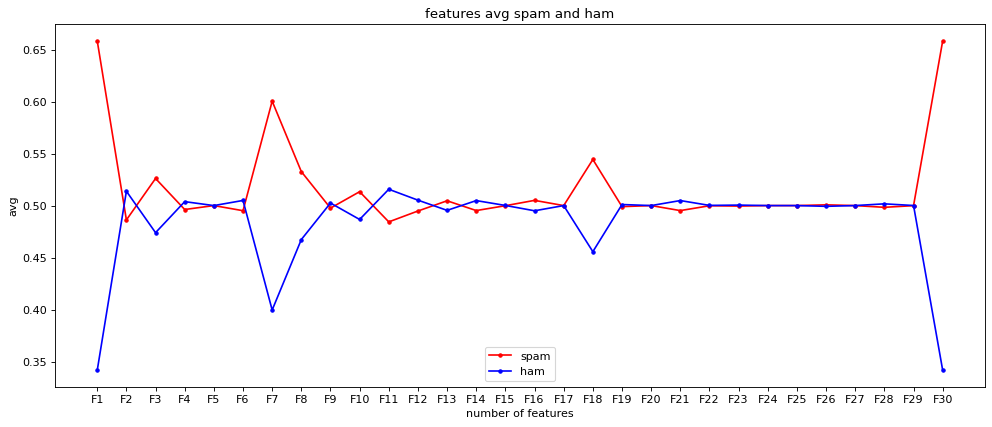

In [ ]:
x = np.array(list(avg_featurs_spam.values()))
y = np.array(list(avg_featurs_ham.values()))
figure(figsize=(15, 6), dpi=80)
plt.plot(featurs_list,(x+1)/(x+y+2),label="spam", color='red',marker='.')
plt.plot(featurs_list,(y+1)/(x+y+2),label="ham", color='blue',marker='.')
plt.xlabel('number of features')
plt.ylabel('avg')
plt.legend(['spam','ham'])
plt.title('features avg spam and ham')
plt.show()

##Featurs slection

<div dir=rtl>
در نمودار بالا بار دیگر میانگین هر ویژگی را برای هر کلاس محاسبه کردیم و نمایش دادیم. 
حال برای انتخاب بهترین ویژگی ها برای آموزش از ضریب همبستگی استفاده میکنیم که برای این منظور ضریب همبستگی هر ستون ویژگی را با ستون target که هم ستون برچسب ها است که تبدیل به کلاس 0 و 1 شده است.
و سپس هر ستونی که قدر مطلق مقدار ضریب همبستگی آن کمتر 0.15 و یا nan است را حذف کرده و سپس پارامتر ها و احتمال های مدل را بر روی داده آموزش بدست میاوریم و بعد داده های آزمون و ارزیابی را توسط مدل اموزش دیده برچسب میزنیم.
</div>

In [ ]:
train_set_fs.insert(1, "target", "Any") #converting classes label to 0 & 1 
Target = {'ham': 1,'spam': 0}
train_set_fs.target = [Target[item] for item in train_set_fs.class_label]
train_set_fs.head()


,class_label,target,Text_mail,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,ham,1,Watch lor. I saw a few swatch one i thk quite ...,87,0.678161,0.045977,0.218391,0.0,0.057471,19,2.950000,0.894737,0.210526,0.736842,0.842105,0.000000,166.204986,0.017544,0.000000,0,3.997670,0.0,0.0,0.057471,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011494,0,87.0
1,ham,1,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56,0.696429,0.017857,0.250000,0.0,0.035714,14,2.600000,0.928571,0.142857,0.785714,0.857143,0.071429,102.040816,0.010989,0.071429,0,3.664498,0.0,0.0,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,56.0
2,ham,1,No just send to you. Bec you in temple na.,42,0.738095,0.000000,0.214286,0.0,0.047619,10,2.818182,0.900000,0.100000,0.700000,0.800000,0.100000,200.000000,0.022222,0.100000,0,3.121928,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,42.0
3,ham,1,How u doin baby girl ?? hope u are okay every ...,97,0.731959,0.000000,0.237113,0.0,0.030928,23,2.958333,0.869565,0.130435,0.521739,0.782609,0.043478,151.228733,0.015810,0.047619,0,4.229871,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010309,0.0,0.000000,0,97.0
4,ham,1,No da:)he is stupid da..always sending like th...,102,0.764706,0.000000,0.147059,0.0,0.088235,20,3.714286,0.900000,0.400000,0.500000,0.800000,0.100000,100.000000,0.010526,0.105263,0,4.121928,0.0,0.0,0.029412,0.029412,0.0,0.0,0.0,0.000000,0.0,0.009804,0,102.0


In [ ]:
#adding a row for calculate correlation coefficient of each features
correlation_coefficient = pd.Series([])
row_train_set_fs = pd.DataFrame([correlation_coefficient], index = ["-1"])
train_set_fs = pd.concat([row_train_set_fs, train_set_fs])
train_set_fs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,class_label,target,Text_mail,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ham,1.0,Watch lor. I saw a few swatch one i thk quite ...,87.0,0.678161,0.045977,0.218391,0.0,0.057471,19.0,2.950000,0.894737,0.210526,0.736842,0.842105,0.000000,166.204986,0.017544,0.000000,0.0,3.997670,0.0,0.0,0.057471,0.0,0.0,0.0,0.0,0.000000,0.0,0.011494,0.0,87.0
1,ham,1.0,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56.0,0.696429,0.017857,0.250000,0.0,0.035714,14.0,2.600000,0.928571,0.142857,0.785714,0.857143,0.071429,102.040816,0.010989,0.071429,0.0,3.664498,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,56.0
2,ham,1.0,No just send to you. Bec you in temple na.,42.0,0.738095,0.000000,0.214286,0.0,0.047619,10.0,2.818182,0.900000,0.100000,0.700000,0.800000,0.100000,200.000000,0.022222,0.100000,0.0,3.121928,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,42.0
3,ham,1.0,How u doin baby girl ?? hope u are okay every ...,97.0,0.731959,0.000000,0.237113,0.0,0.030928,23.0,2.958333,0.869565,0.130435,0.521739,0.782609,0.043478,151.228733,0.015810,0.047619,0.0,4.229871,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010309,0.0,0.000000,0.0,97.0


In [ ]:
#calculate correlation coefficient of each features
for feature in featurs_list:
  train_set_fs.loc['-1',[feature]] = train_set_fs['target'].corr(train_set_fs[feature])
train_set_fs.head()

,class_label,target,Text_mail,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
-1,NaN,NaN,NaN,-0.380515,0.439302,-0.793521,0.175991,NaN,0.120942,-0.23439,-0.314649,0.079834,-0.161555,0.194634,0.095375,-0.116924,0.003675,0.011055,-0.111509,NaN,-0.322160,0.131469,NaN,0.134697,0.022371,0.080971,NaN,NaN,-0.117947,0.016962,0.132413,0.00623,-0.380637
0,ham,1.0,Watch lor. I saw a few swatch one i thk quite ...,87.000000,0.678161,0.045977,0.218391,0.0,0.057471,19.00000,2.950000,0.894737,0.210526,0.736842,0.842105,0.000000,166.204986,0.017544,0.000000,0.0,3.997670,0.000000,0.0,0.057471,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.011494,0.00000,87.000000
1,ham,1.0,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56.000000,0.696429,0.017857,0.250000,0.0,0.035714,14.00000,2.600000,0.928571,0.142857,0.785714,0.857143,0.071429,102.040816,0.010989,0.071429,0.0,3.664498,0.000000,0.0,0.017857,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,56.000000
2,ham,1.0,No just send to you. Bec you in temple na.,42.000000,0.738095,0.000000,0.214286,0.0,0.047619,10.00000,2.818182,0.900000,0.100000,0.700000,0.800000,0.100000,200.000000,0.022222,0.100000,0.0,3.121928,0.000000,0.0,0.047619,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,42.000000
3,ham,1.0,How u doin baby girl ?? hope u are okay every ...,97.000000,0.731959,0.000000,0.237113,0.0,0.030928,23.00000,2.958333,0.869565,0.130435,0.521739,0.782609,0.043478,151.228733,0.015810,0.047619,0.0,4.229871,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010309,0.000000,0.000000,0.00000,97.000000


In [ ]:
#drop collemns that that thir absolute correlation coefficient values less than 0.15 or equal NaN
for feature in featurs_list:
  if abs(train_set_fs.iloc[0][feature]) < 0.15 or str(train_set_fs.iloc[0][feature]) == 'nan':
      train_set_fs = train_set_fs.drop(columns=[feature])
train_set_fs.head()

,class_label,target,Text_mail,F1,F2,F3,F4,F7,F8,F10,F11,F18,F30
-1,NaN,NaN,NaN,-0.380515,0.439302,-0.793521,0.175991,-0.23439,-0.314649,-0.161555,0.194634,-0.322160,-0.380637
0,ham,1.0,Watch lor. I saw a few swatch one i thk quite ...,87.000000,0.678161,0.045977,0.218391,19.00000,2.950000,0.210526,0.736842,3.997670,87.000000
1,ham,1.0,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56.000000,0.696429,0.017857,0.250000,14.00000,2.600000,0.142857,0.785714,3.664498,56.000000
2,ham,1.0,No just send to you. Bec you in temple na.,42.000000,0.738095,0.000000,0.214286,10.00000,2.818182,0.100000,0.700000,3.121928,42.000000
3,ham,1.0,How u doin baby girl ?? hope u are okay every ...,97.000000,0.731959,0.000000,0.237113,23.00000,2.958333,0.130435,0.521739,4.229871,97.000000


In [ ]:
#drop row of correlation coefficient and target collemn
train_set_fs = train_set_fs.drop('-1')
train_set_fs = train_set_fs.drop(columns=['target'])
train_set_fs.head()

,class_label,Text_mail,F1,F2,F3,F4,F7,F8,F10,F11,F18,F30
0,ham,Watch lor. I saw a few swatch one i thk quite ...,87.0,0.678161,0.045977,0.218391,19.0,2.950000,0.210526,0.736842,3.997670,87.0
1,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,56.0,0.696429,0.017857,0.250000,14.0,2.600000,0.142857,0.785714,3.664498,56.0
2,ham,No just send to you. Bec you in temple na.,42.0,0.738095,0.000000,0.214286,10.0,2.818182,0.100000,0.700000,3.121928,42.0
3,ham,How u doin baby girl ?? hope u are okay every ...,97.0,0.731959,0.000000,0.237113,23.0,2.958333,0.130435,0.521739,4.229871,97.0
4,ham,No da:)he is stupid da..always sending like th...,102.0,0.764706,0.000000,0.147059,20.0,3.714286,0.400000,0.500000,4.121928,102.0


<div dir=rtl>
همانطور که مشاهده میکنید از 30 ویژگی استخراج شده 10 ویژگی را انتخاب میکنیم و برای آموزش و مدل دسته بندی نِیو بیز استفاده میکنیم. در ادامه دوباره پارامتر های مربوط و میانگین ویژگی ها برای هر ویژگی را محاسبه میکنیم و نمودار این میانگین ها را به ازای هر کلاس و ویژگی رسم میکنیم.
</div>

In [ ]:
# Isolating spam and ham messages first
spam_messages = train_set_fs[train_set_fs['class_label'] == 'spam']
ham_messages = train_set_fs[train_set_fs['class_label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_set)
p_ham = len(ham_messages) / len(train_set)

# N_Features
featurs_list = train_set_fs.columns[2:]
n_features = len(featurs_list) # number of features

# Laplace smoothing
alpha = 0.01

avg_featurs_spam = {}
avg_featurs_ham = {}
for feature in featurs_list:
  avg_featurs_spam[feature] = spam_messages[feature].mean() 
  avg_featurs_ham[feature] = ham_messages[feature].mean()

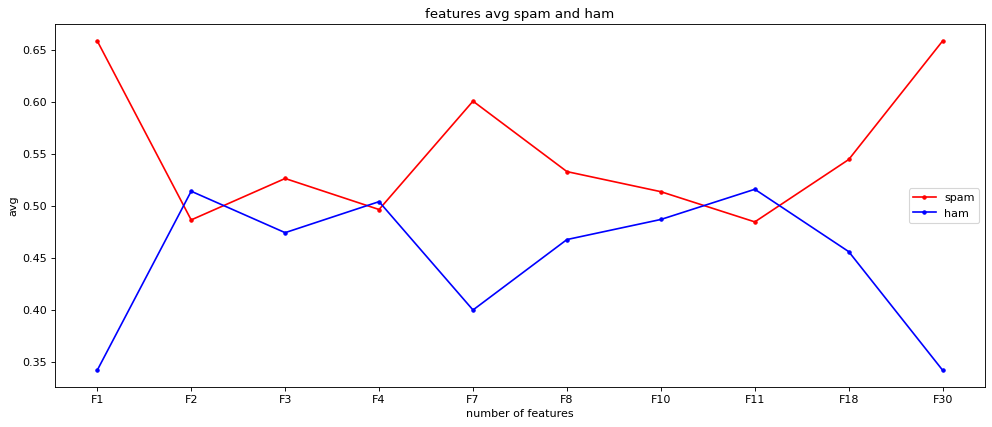

In [ ]:
x = np.array(list(avg_featurs_spam.values()))
y = np.array(list(avg_featurs_ham.values()))
figure(figsize=(15, 6), dpi=80)
plt.plot(featurs_list,(x+1)/(x+y+2),label="spam", color='red',marker='.')
plt.plot(featurs_list,(y+1)/(x+y+2),label="ham", color='blue',marker='.')
plt.xlabel('number of features')
plt.ylabel('avg')
plt.legend(['spam','ham'])
plt.title('features avg spam and ham')
plt.show()

<div dir=rtl>
در نمودار بالا اختلاف بین میانگین ویژگی های هر کلاس این موضوع را به خوبی نشان می دهد که این ویژگی ها برای دسته بندی و آموزش کارایی خوبی از خود نشان میدهد و انتظار می رود  که مدل دسته بند با این ویژگی ها نسبت به مدل قبلی ( که دارای 30 ویژگی بود) عملکرد بهتری داشته باشد.
</div>

In [ ]:
import re

def classify_fs_test_set(df): # classify by features test set
   '''
   Evaluate test_set
   '''
   ########################### preprocessing and extract features ############# 
   test = preprocessing_features_extraction(df)
   test_set = test.preprocessing(df)
   test_set = test.features_extractor(df)



   test_set.insert(2, "predicted", "Any")
   
   for index in range(len(test_set)):
      p_spam_given_message = p_spam
      p_ham_given_message = p_ham
      for feature in featurs_list:            
            distance_parameters_spam = abs(avg_featurs_spam[feature] - test_set[feature][index])
            distance_parameters_ham = abs(avg_featurs_ham[feature] - test_set[feature][index])
            p_parameter_spam = 1 - (distance_parameters_spam  / ((distance_parameters_spam + distance_parameters_ham + alpha )))
            p_parameter_ham = 1 -  (distance_parameters_ham  /  ((distance_parameters_spam + distance_parameters_ham + alpha )))
            p_spam_given_message *= p_parameter_spam
            p_ham_given_message *= p_parameter_ham    
      if  p_ham_given_message >= p_spam_given_message:
        test_set['predicted'][index] = 'ham'
      else:
        test_set['predicted'][index] = 'spam'
   return test_set

In [ ]:
test_set_fs = classify_fs_test_set(test_set_fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_set_fs = test_set_fs.drop(test_set_fs.columns[3:], axis=1)
test_set_fs.head()

,class_label,Text_mail,predicted
0,ham,He like not v shock leh. Cos telling shuhui is...,spam
1,ham,I'm job profile seems like bpo..,ham
2,ham,Ok then i come n pick u at engin?,ham
3,ham,You do what all you like,ham
4,ham,Dear :-/ why you mood off. I cant drive so i b...,ham


##classification reports

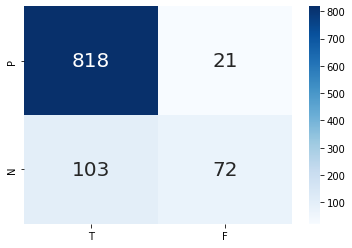

True Positive = 818 False Negative = 21 True Negative 103 False Negative = 72
Correct : 921
Incorrect : 93
Precision :  0.9749702026221693
Recall :  0.9191011235955057
Accuracy : 0.908284023668639
F1_Measure :  0.9462116830537883
specificity :  0.8306451612903226


In [ ]:
correct = 0
total = test_set_fs.shape[0]
TP = FP = TN = FN =0
for row in test_set_fs.iterrows():
   row = row[1]
   if row['class_label'] == row['predicted']:
      correct += 1
   if row['class_label'] == 'ham':
     if row['predicted'] == 'ham':
        TP+=1
     else:
        FN+=1
   else:
     if row['predicted'] == 'ham':
        FP+=1
     else:
        TN+=1
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
F1_Measure = (2 * precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

array = [[TP,FP],[TN,FN]] 
df_cm = pd.DataFrame(array, ['P','N'], ['T','F'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g',annot_kws={"size": 20})
plt.show()

print('True Positive =', TP, 'False Negative =', FP,'True Negative', TN,'False Negative =', FN)
print('Correct :', correct)
print('Incorrect :', total - correct)
print('Precision : ', precision)
print('Recall : ', recall)
print('Accuracy :', accuracy)
print('F1_Measure : ', F1_Measure)
print('specificity : ', specificity)

##Predicted gold testset

In [ ]:
url_eval_fs = 'https://drive.google.com/u/0/uc?id=1ym6-KsCfkXPivS4gm18-45q4mTiBbNFm&export=download'
eval_set_fs = pd.read_csv(url_eval_fs) #Read Dataset evaluation
eval_set_fs = eval_set_fs.rename(columns={"text": "Text_mail"})
eval_set_fs.head()

,id,Text_mail
0,1,"Go until jurong point, crazy.. Available only ..."
1,2,Ok lar... Joking wif u oni...
2,3,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,U dun say so early hor... U c already then say...
4,5,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
eval_set_fs = classify_fs_test_set(eval_set_fs)
eval_set_fs = eval_set_fs.drop(eval_set_fs.columns[3:], axis=1)
eval_set_fs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,Text_mail,predicted
0,1,"Go until jurong point, crazy.. Available only ...",spam
1,2,Ok lar... Joking wif u oni...,ham
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,4,U dun say so early hor... U c already then say...,ham
4,5,"Nah I don't think he goes to usf, he lives aro...",ham


In [ ]:
del eval_set_fs['Text_mail']
eval_set_fs = eval_set_fs.rename(columns={"predicted": "type"})
eval_set_fs.head()

,id,type
0,1,spam
1,2,ham
2,3,spam
3,4,ham
4,5,ham


In [ ]:
eval_set_fs.to_csv('99210323_eval_output_Features_selection.csv',index=False)


In [ ]:
from google.colab import files
files.download('99210323_eval_output_Features_selection.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>